In [1]:
import sys
import json
import warnings

import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import PyComplexHeatmap as pch
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

sys.path.append('../..')
from anndata import AnnData
from data_list import get_scanpy_adata
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib.colors import LinearSegmentedColormap
from utils import UnimapResult, set_plot_theme, generate_positions
set_plot_theme()
warnings.filterwarnings('ignore')

/home/hht/.conda/envs/unimap1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def sum_lists(dict):
  result = []
  for key, values in dict.items():
    result.extend(values)
  return result

def remove_duplicates(list1):
  list2 = []
  for i in list1:
    is_duplicate = False
    for j in range(len(list2)):
      if i == list2[j]:
        is_duplicate = True
        break
    if not is_duplicate:
      list2.append(i)
  return list2

def get_heat_info_df(meta, pred_ct_list, species='human'):
    heat_info_df = pd.DataFrame(index=pred_ct_list)

    heat_info_df['pred_celltype'] = pred_ct_list  
    heat_info_df.insert(1,'ct_num', meta.pred_celltype.value_counts())  
    heat_info_df.insert(2,'species', species) 

    # 计算混淆矩阵
    cm = confusion_matrix(meta['pred_celltype'], meta['celltype'])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    celltype_labels = sorted(set(meta['pred_celltype']) | set(meta['celltype']))
    cm = pd.DataFrame(cm, index=celltype_labels, columns=celltype_labels)
    cm = cm.loc[pred_ct_list, pred_ct_list]
    heat_info_df = pd.concat([heat_info_df, cm], axis=1)
    return heat_info_df


In [3]:
unimap_result = UnimapResult('cross_species', 'unimap/2023', root_dir='../../results')

s_data, t_data = get_scanpy_adata('cross_species')
st_data = sc.concat([s_data, t_data], join='outer')

hq_list = unimap_result.st_result[unimap_result.st_result['pred_cell_prob'] > 0.25].index
human_index = unimap_result.st_result[unimap_result.st_result['batch'] == 'human'].index
mf_index = unimap_result.st_result[unimap_result.st_result['batch'] == 'macaqueF'].index
mouse_index = unimap_result.st_result[unimap_result.st_result['batch'] == 'mouse'].index
mm_index = unimap_result.st_result[unimap_result.st_result['batch'] == 'macaqueM'].index

human_meta = unimap_result.st_result.loc[human_index]
mf_meta = unimap_result.st_result.loc[mf_index]
mouse_meta = unimap_result.st_result.loc[mouse_index]
mm_meta = unimap_result.st_result.loc[mm_index]


pred_ct_list = ['Schwann Cell',  'Melanocyte', 'Corneal Epithelium Cell', 'Beam Cell', 'JCT Cell', 
                'CiliaryMuscle Cell', 'Pericyte', 'Vascular Endothelium Cell', 'Macrophage Cell', 'NK/T Cell']


human_ad = sc.AnnData(X=st_data[st_data.obs.index.isin(human_index)].X, obs=human_meta, var=st_data.var)
human_ad = human_ad[human_ad.obs.pred_celltype.isin(pred_ct_list)]
human_ad_hq = human_ad

mf_ad = sc.AnnData(X=st_data[st_data.obs.index.isin(mf_index)].X, obs=mf_meta, var=st_data.var)
mf_ad = mf_ad[mf_ad.obs.pred_celltype.isin(pred_ct_list)]
mf_ad_hq = mf_ad[mf_ad.obs.index.isin(hq_list)]

mouse_ad = sc.AnnData(X=st_data[st_data.obs.index.isin(mouse_index)].X, obs=mouse_meta, var=st_data.var)
mouse_ad = mouse_ad[mouse_ad.obs.pred_celltype.isin(pred_ct_list)]
mouse_ad_hq = mouse_ad[mouse_ad.obs.index.isin(hq_list)]

mm_ad = sc.AnnData(X=st_data[st_data.obs.index.isin(mm_index)].X, obs=mm_meta, var=st_data.var)
mm_ad = mm_ad[mm_ad.obs.pred_celltype.isin(pred_ct_list)]
mm_ad_hq = mm_ad[mm_ad.obs.index.isin(hq_list)]


sc.tl.rank_genes_groups(human_ad_hq, 'pred_celltype', method='t-test')
sc.tl.rank_genes_groups(mf_ad_hq, 'pred_celltype', method='t-test')
sc.tl.rank_genes_groups(mouse_ad_hq, 'pred_celltype', method='t-test')
sc.tl.rank_genes_groups(mm_ad_hq, 'pred_celltype', method='t-test')

marker_genes_dict = {}
for ct in pred_ct_list:
    marker_genes1 = pd.DataFrame(human_ad_hq.uns['rank_genes_groups']['names'])[ct].head(10)
    # marker_genes2 = pd.DataFrame(pig_ad.uns['rank_genes_groups']['names'])[ct].head(10)
    marker_genes3 = pd.DataFrame(mf_ad_hq.uns['rank_genes_groups']['names'])[ct].head(10)
    marker_genes4 = pd.DataFrame(mouse_ad_hq.uns['rank_genes_groups']['names'])[ct].head(10)
    marker_genes2 = pd.DataFrame(mm_ad_hq.uns['rank_genes_groups']['names'])[ct].head(10)
    # marker_genes_dict[ct] = list(set(marker_genes1) | set(marker_genes2) | set(marker_genes3) | set(marker_genes4))
    marker_genes_dict[ct] = list(set(marker_genes1) & set(marker_genes2) & set(marker_genes3) & set(marker_genes4))


marker_genes_list = remove_duplicates(sum_lists(marker_genes_dict))
print(len(marker_genes_list))

human_heat_info_df = get_heat_info_df(human_meta, pred_ct_list, species='human')
mf_heat_info_df = get_heat_info_df(mf_meta, pred_ct_list, species='mf')
mouse_heat_info_df = get_heat_info_df(mouse_meta, pred_ct_list, species='mouse')
mm_heat_info_df = get_heat_info_df(mm_meta, pred_ct_list, species='mm')
heat_info_dict = {'human': human_heat_info_df,
                  # 'pig': pig_heat_info_df,
                  'mf': mf_heat_info_df,
                  'mouse': mouse_heat_info_df,
                  'mm': mm_heat_info_df
                  }

logfc_dict = {}
for species in ['human', 'mm', 'mf', 'mouse']:
    logfc_df = pd.DataFrame()
    adict = {}
    for ct in pred_ct_list:
        adict[ct] = pd.DataFrame(eval(species + '_ad_hq.uns')['rank_genes_groups']['logfoldchanges'][ct], index=eval(species + '_ad_hq.uns')['rank_genes_groups']['names'][ct], columns=[ct])
    logfc_df = pd.concat(adict.values(), axis=1)
    logfc_heat_map_data = logfc_df.loc[marker_genes_list]
    logfc_dict[species] = logfc_heat_map_data

gene_group = pd.DataFrame(index=marker_genes_list, columns=['group'])
for ct in pred_ct_list[::-1]:
    gene_group.loc[marker_genes_dict[ct], 'group'] = ct

Checking cross_species unimap/2023 
              result               
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ File                 ┃ Exist    ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ st_result.csv        │ ✔️        │
│ history.csv          │ ✔️        │
│ st_z_result.csv      │ ✔️        │
│ st_umap_result.csv   │ ✔️        │
│ t_prob_result.csv    │ ✔️        │
└──────────────────────┴──────────┘

13


In [4]:
# # human_ad = sc.AnnData(X=st_data[st_data.obs.index.isin(human_index)].X, obs=human_meta, var=st_data.var)
# list(human_ad.obs.celltype.value_counts().index)

In [5]:
# od_marker = [ "POU6F2", "CPAMD8", "FOXC1", "PITX2", "MYOC", "LOXL1", "CYP1B1", "LTBP2", "KALRN", "DGKG", "ANGPT2", "TEK", "CAV1", "CAV2", "GAS7"]
od_marker1 = ["DCN", "MGP", "RARRES1", "OGN", "RBP4", "SFRP4", "IGFBP2", "ANGPTL7", "EDN3", "PDPN", "C7", "BMP5", "TMEFF2", "PPP1R1B", "CEMIP", "CHI3L1"]
od_marker2 = ["NDUFA4L2", "GJA4", "PDGFRB", "ACTA2", "MYH11", "MYLK", "DES", "TRPM1", "MITF", "EDNRB", "MBP", "PLP1", "CDH19"]

# 求od_marker和marker_genes_list有多少个重复的
set(set(od_marker1) | set(od_marker2)) & set(marker_genes_list)

{'CDH19', 'EDNRB', 'IGFBP2', 'MGP', 'MITF', 'MYLK'}

In [6]:
len(set(set(od_marker1) | set(od_marker2)) & set(marker_genes_list)) / len(set(set(od_marker1) | set(od_marker2)))

0.20689655172413793

In [7]:
def cal_gene(adata: AnnData, gene_list: list, groupby_column: str) -> pd.DataFrame:
    valid_genes = [gene for gene in gene_list if gene in adata.var_names]
    expression_matrix = adata[:, valid_genes].X
    groups = adata.obs[groupby_column]

    if not isinstance(expression_matrix, np.ndarray):
        expression_matrix = expression_matrix.toarray()

    results = {
        'group': [],
        'gene': [],
        'expression_proportion': [],
        'average_expression': []
    }

    for group in groups.unique():
        group_mask = (groups == group).values
        group_expression = expression_matrix[group_mask, :]
        
        expression_proportion = (group_expression > 0).sum(axis=0) / group_expression.shape[0]
        average_expression = group_expression.mean(axis=0)
        
        for gene, prop, avg in zip(valid_genes, expression_proportion, average_expression):
            results['group'].append(group)
            results['gene'].append(gene)
            results['expression_proportion'].append(prop)
            results['average_expression'].append(avg)

    return pd.DataFrame(results)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from anndata import AnnData

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from anndata import AnnData

def plot_dotplot(adata: AnnData, gene_list: list, groupby_column: str, ax=None, group_color=['#a0a0a0', '#c3a74d'], group_index=None, xlist=None, palette='viridis'):
    df = cal_gene(adata, gene_list, groupby_column)
    df['gene'] = pd.Categorical(df['gene'], categories=gene_list[::-1], ordered=True)
    df = df.sort_values('gene')
    gene_num = len(gene_list)

    if group_index is None:
        unique_groups = df['group'].unique()
    else:
        unique_groups = group_index
    
    if xlist is not None:
        # Ensure xlist is a subset of the unique_groups
        xlist = [x for x in xlist if x in unique_groups]
        df['group'] = pd.Categorical(df['group'], categories=xlist, ordered=True)
        df = df[df['group'].isin(xlist)]

    df['group'] = pd.Categorical(df['group'], categories=xlist or unique_groups, ordered=True)
    group_num = len(df['group'].cat.categories)

    p = sns.scatterplot(data=df, x='group', y='gene', size='expression_proportion', hue='average_expression', palette=palette, sizes=(0, 35), edgecolor='black', linewidth=0.0, ax=ax)
    p.legend_.remove()

    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xlim(-0.5, group_num - 0.5)
    p.set_ylim(-1, gene_num)
    
    # Modify x-tick labels
    p.set_xticks(range(group_num))
    p.set_xticklabels(xlist or unique_groups, fontsize=5, rotation=45, ha='right')
    
    p.set_yticklabels(gene_list[::-1], fontsize=5, fontstyle='italic')
    p.xaxis.set_tick_params(labelsize=5, pad=0)
    p.yaxis.set_tick_params(labelsize=5, pad=2)
    p.tick_params(bottom=True, top=False, left=True, right=False, length=1, width=0.5)
    # for tick, color in zip(p.get_xticklabels(), group_color):
    #     tick.set_color(color)

    return df



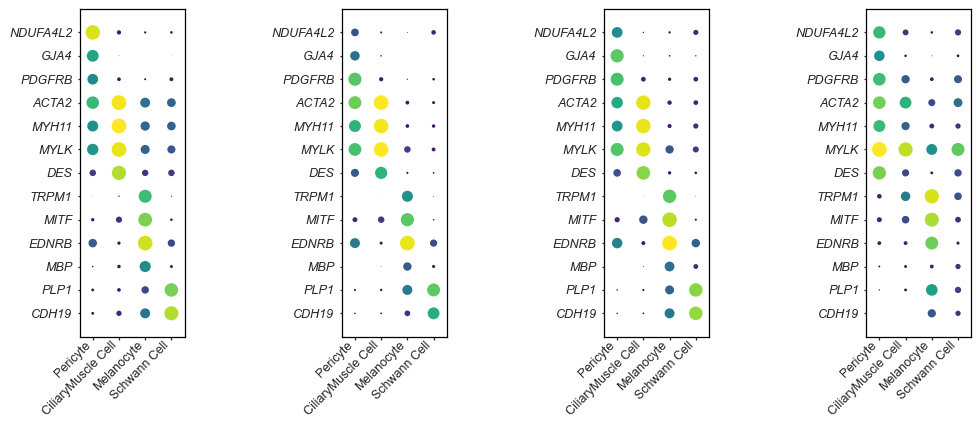

In [8]:
ct1 = ['Beam Cell', 'JCT Cell']
ct2 = ['Pericyte', 'CiliaryMuscle Cell', 'Melanocyte', 'Schwann Cell']
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()
postions = [
            [0.05, 0.1, 0.08, 0.25 / (250/185)],
            [0.25, 0.1, 0.08, 0.25 / (250/185)],
            [0.45, 0.1, 0.08, 0.25 / (250/185)],
            [0.65, 0.1, 0.08, 0.25 / (250/185)],
            ]
ax1 = fig.add_axes(postions[0])
ax2 = fig.add_axes(postions[1])
ax3 = fig.add_axes(postions[2])
ax4 = fig.add_axes(postions[3])

human_ad2 = human_ad[human_ad.obs.pred_celltype.isin(ct2)].copy()
mf_ad2 = mf_ad[mf_ad.obs.pred_celltype.isin(ct2)].copy()
mm_ad2 = mm_ad[mm_ad.obs.pred_celltype.isin(ct2)].copy()
mouse_ad2 = mouse_ad[mouse_ad.obs.pred_celltype.isin(ct2)].copy()


p1 = plot_dotplot(human_ad2, od_marker2, groupby_column='pred_celltype', ax=ax1, xlist=ct2)
p2 = plot_dotplot(mf_ad2, od_marker2, groupby_column='pred_celltype', ax=ax2, xlist=ct2)
p3 = plot_dotplot(mm_ad2, od_marker2, groupby_column='pred_celltype', ax=ax3, xlist=ct2)
p4 = plot_dotplot(mouse_ad2, od_marker2, groupby_column='pred_celltype', ax=ax4, xlist=ct2)

In [9]:
ct1 = ['Beam Cell', 'JCT Cell']
ct2 = ['Pericyte', 'CiliaryMuscle Cell', 'Melanocyte', 'Schwann Cell']
# fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
# axs.remove()
postions = [
            [0.05, 0.4, 0.08, 0.25 / (250/185)],
            [0.25, 0.4, 0.08, 0.25 / (250/185)],
            [0.45, 0.4, 0.08, 0.25 / (250/185)],
            [0.65, 0.4, 0.08, 0.25 / (250/185)],
            ]
ax1 = fig.add_axes(postions[0])
ax2 = fig.add_axes(postions[1])
ax3 = fig.add_axes(postions[2])
ax4 = fig.add_axes(postions[3])

human_ad2 = human_ad[human_ad.obs.pred_celltype.isin(ct2)].copy()
mf_ad2 = mf_ad[mf_ad.obs.pred_celltype.isin(ct2)].copy()
mm_ad2 = mm_ad[mm_ad.obs.pred_celltype.isin(ct2)].copy()
mouse_ad2 = mouse_ad[mouse_ad.obs.pred_celltype.isin(ct2)].copy()


p1 = plot_dotplot(human_ad2, od_marker2, groupby_column='celltype', ax=ax1, xlist=ct2)
p2 = plot_dotplot(mf_ad2, od_marker2, groupby_column='celltype', ax=ax2, xlist=ct2)
p3 = plot_dotplot(mm_ad2, od_marker2, groupby_column='celltype', ax=ax3, xlist=ct2)
p4 = plot_dotplot(mouse_ad2, od_marker2, groupby_column='celltype', ax=ax4, xlist=ct2)

In [10]:
ct1 = ['Beam Cell', 'JCT Cell']
ct2 = ['Pericyte', 'CiliaryMuscle Cell', 'Melanocyte', 'Schwann Cell']
# fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
# axs.remove()
postions = [
            [0.05, 0.7, 0.08, 0.25 / (250/185)],
            [0.25, 0.7, 0.08, 0.25 / (250/185)],
            [0.45, 0.7, 0.08, 0.25 / (250/185)],
            [0.65, 0.7, 0.08, 0.25 / (250/185)],
            ]
ax1 = fig.add_axes(postions[0])
ax2 = fig.add_axes(postions[1])
ax3 = fig.add_axes(postions[2])
ax4 = fig.add_axes(postions[3])

human_ad3 = human_ad_hq[human_ad_hq.obs.pred_celltype.isin(ct2)].copy()
mf_ad3 = mf_ad_hq[mf_ad_hq.obs.pred_celltype.isin(ct2)].copy()
mm_ad3 = mm_ad_hq[mm_ad_hq.obs.pred_celltype.isin(ct2)].copy()
mouse_ad3 = mouse_ad_hq[mouse_ad_hq.obs.pred_celltype.isin(ct2)].copy()


p1 = plot_dotplot(human_ad3, od_marker2, groupby_column='pred_celltype', ax=ax1, xlist=ct2)
p2 = plot_dotplot(mf_ad3, od_marker2, groupby_column='pred_celltype', ax=ax2, xlist=ct2)
p3 = plot_dotplot(mm_ad3, od_marker2, groupby_column='pred_celltype', ax=ax3, xlist=ct2)
p4 = plot_dotplot(mouse_ad3, od_marker2, groupby_column='pred_celltype', ax=ax4, xlist=ct2)

In [11]:
fig
fig.savefig('../figs/supplementary fig18.pdf', dpi=720)

In [12]:
row_data_celltype_value_counts = pd.concat([human_meta.celltype.value_counts(), mf_meta.celltype.value_counts(), mm_meta.celltype.value_counts(), mouse_meta.celltype.value_counts()], axis=1)
row_data_celltype_value_counts.fillna(0, inplace=True)

# 重新设置col
row_data_celltype_value_counts.columns = ['human', 'macaqueF', 'macaqueM', 'mouse']
# row_data_celltype_value_counts.to_csv('row_data_celltype_value_counts.csv')

In [13]:
# human
log_fc_p_df = pd.DataFrame(columns=['logfc', 'pvals_adj', 'celltype'], index=pd.Index(name='Name', data=[]))
for ct in human_ad_hq.obs.celltype.unique():
    Name = human_ad_hq.uns['rank_genes_groups']['names'][ct]
    logfc = human_ad_hq.uns['rank_genes_groups']['logfoldchanges'][ct]
    pvals_adj = human_ad_hq.uns['rank_genes_groups']['pvals'][ct]
    celltype = [ct] * len(Name)  # pvals_adj
    log_fc_p_df_ct = pd.DataFrame({'logfc': logfc, 'pvals_adj': pvals_adj, 'celltype': celltype}, index=pd.Index(name='Name', data=Name))
    log_fc_p_df = pd.concat([log_fc_p_df, log_fc_p_df_ct])
log_fc_p_df['fc'] = 2 ** log_fc_p_df['logfc']
log_fc_p_df.to_csv('human_logfc_pvalsadj_celltype.csv')

In [14]:
# mm
log_fc_p_df = pd.DataFrame(columns=['logfc', 'pvals_adj', 'celltype'], index=pd.Index(name='Name', data=[]))
for ct in human_ad_hq.obs.celltype.unique():
    Name = mm_ad_hq.uns['rank_genes_groups']['names'][ct]
    logfc = mm_ad_hq.uns['rank_genes_groups']['logfoldchanges'][ct]
    pvals_adj = mm_ad_hq.uns['rank_genes_groups']['pvals'][ct]
    celltype = [ct] * len(Name)  # pvals_adj
    log_fc_p_df_ct = pd.DataFrame({'logfc': logfc, 'pvals_adj': pvals_adj, 'celltype': celltype}, index=pd.Index(name='Name', data=Name))
    log_fc_p_df = pd.concat([log_fc_p_df, log_fc_p_df_ct])
log_fc_p_df['fc'] = 2 ** log_fc_p_df['logfc']
log_fc_p_df.to_csv('mm_logfc_pvalsadj_celltype.csv')

In [15]:
# mf
log_fc_p_df = pd.DataFrame(columns=['logfc', 'pvals_adj', 'celltype'], index=pd.Index(name='Name', data=[]))
for ct in human_ad_hq.obs.celltype.unique():
    Name = mf_ad_hq.uns['rank_genes_groups']['names'][ct]
    logfc = mf_ad_hq.uns['rank_genes_groups']['logfoldchanges'][ct]
    pvals_adj = mf_ad_hq.uns['rank_genes_groups']['pvals'][ct]
    celltype = [ct] * len(Name)  # pvals_adj
    log_fc_p_df_ct = pd.DataFrame({'logfc': logfc, 'pvals_adj': pvals_adj, 'celltype': celltype}, index=pd.Index(name='Name', data=Name))
    log_fc_p_df = pd.concat([log_fc_p_df, log_fc_p_df_ct])
log_fc_p_df['fc'] = 2 ** log_fc_p_df['logfc']
log_fc_p_df.to_csv('mf_logfc_pvalsadj_celltype.csv')

In [16]:
# mouse
log_fc_p_df = pd.DataFrame(columns=['logfc', 'pvals_adj', 'celltype'], index=pd.Index(name='Name', data=[]))
for ct in human_ad_hq.obs.celltype.unique():
    Name = mouse_ad_hq.uns['rank_genes_groups']['names'][ct]
    logfc = mouse_ad_hq.uns['rank_genes_groups']['logfoldchanges'][ct]
    pvals_adj = mouse_ad_hq.uns['rank_genes_groups']['pvals'][ct]
    celltype = [ct] * len(Name)  # pvals_adj
    log_fc_p_df_ct = pd.DataFrame({'logfc': logfc, 'pvals_adj': pvals_adj, 'celltype': celltype}, index=pd.Index(name='Name', data=Name))
    log_fc_p_df = pd.concat([log_fc_p_df, log_fc_p_df_ct])
log_fc_p_df['fc'] = 2 ** log_fc_p_df['logfc']
log_fc_p_df.to_csv('mouse_logfc_pvalsadj_celltype.csv')

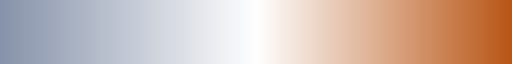

In [17]:
def plot_heatmap(heat_info_dict, species='human', legend=False, need_row_ha=False, gene_group=None, logfc_dict=None, vmax=15, vmin=-15, color_dict=None, title='123', heat_cmap='RdBu_r'):
    heat_info_df = heat_info_dict[species]
    plt.figure(figsize=(5, 8))
    col_ha = pch.HeatmapAnnotation(
                            # species=pch.anno_simple(heat_info_df['species'],add_text=True, legend=False, colors='red', ),  # species
                            # label_side='top',
                            # label=pch.anno_label('HUMAN', merge=True,rotation=15),
                            category=pch.anno_simple(heat_info_df['pred_celltype'],add_text=False, legend=False, colors=color_dict),  # celltype
                            percentage=pch.anno_barplot(heat_info_df.iloc[:,3:],legend=False, cmap=color_list),  # percentage
                            number=pch.anno_barplot(heat_info_df['ct_num'],legend=False, cmap='Purples'),  # num
                            plot=False,
                            legend=True,
                            legend_gap=5,
                            hgap=2)
    # col_ha.ticklabels_side = 'right'

    if need_row_ha:
        row_ha = pch.HeatmapAnnotation(
                          label=pch.anno_label(gene_group['group'],
                                               merge=True,
                                               extend=False,
                                                colors=color_dict,
                                                alpha=0.5,
                                               adjust_color=True,
                                               luminance=0.75,
                                               relpos=(1,0.5)),

                          _=pch.anno_simple(gene_group['group'],
                                                legend=True,
                                                colors=color_dict
                                                ),
                          verbose=1,
                          axis=0,
                          cmap=color_list, 
                        #   colors=color_dict,
                          plot=False,
                          plot_legend=False)
    else:
        row_ha = None

    cm = pch.ClusterMapPlotter(data=logfc_dict[species],
                       col_cluster=False,
                       row_cluster=False,
                    #    legend=False,
                       subplot_gap=2,
                       top_annotation=col_ha,
                     #   col_split=mf_heat_info_df['pred_celltype'],
                     #   row_split=11,
                     vmax=vmax,
                     vmin=vmin,
                                            legend_kws={'vmax':vmax, 'vmin': vmin},
                       col_split_gap=0.5,
                       row_split_gap=0.8,
                       left_annotation=row_ha,
                      #  label='values',
                     #   row_dendrogram=True,
                      #  show_rownames=True,
                      #  show_colnames=True,
                       row_names_side='left',
                      #  tree_kws={'row_cmap': 'Set1','colors':'blue'},
                       verbose=0,
                       legend=legend,
                       legend_gap=5,
                       cmap=heat_cmap,
                       xticklabels_kws={'labelrotation':-90,'labelcolor':'black'},
                       label=' ')
    plt.savefig(f'heatmap_{species}.pdf', bbox_inches='tight')
    plt.show()
    return cm

color_dict = json.load(open('../../color_dict.json'))
ct_c = color_dict["4_sp_ct"]
# color_list = ListedColormap(['#74c476', '#8ca252', '#9e9ac8', '#9ecae1', '#fd8d3c', '#bd9e39', '#6baed6', '#a55194', '#fdae6b', '#ad494a'])

color_list = ListedColormap([ct_c[ct] for ct in pred_ct_list])
colors = ['#8793aa', 'white', '#b85616']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
custom_cmap

Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations


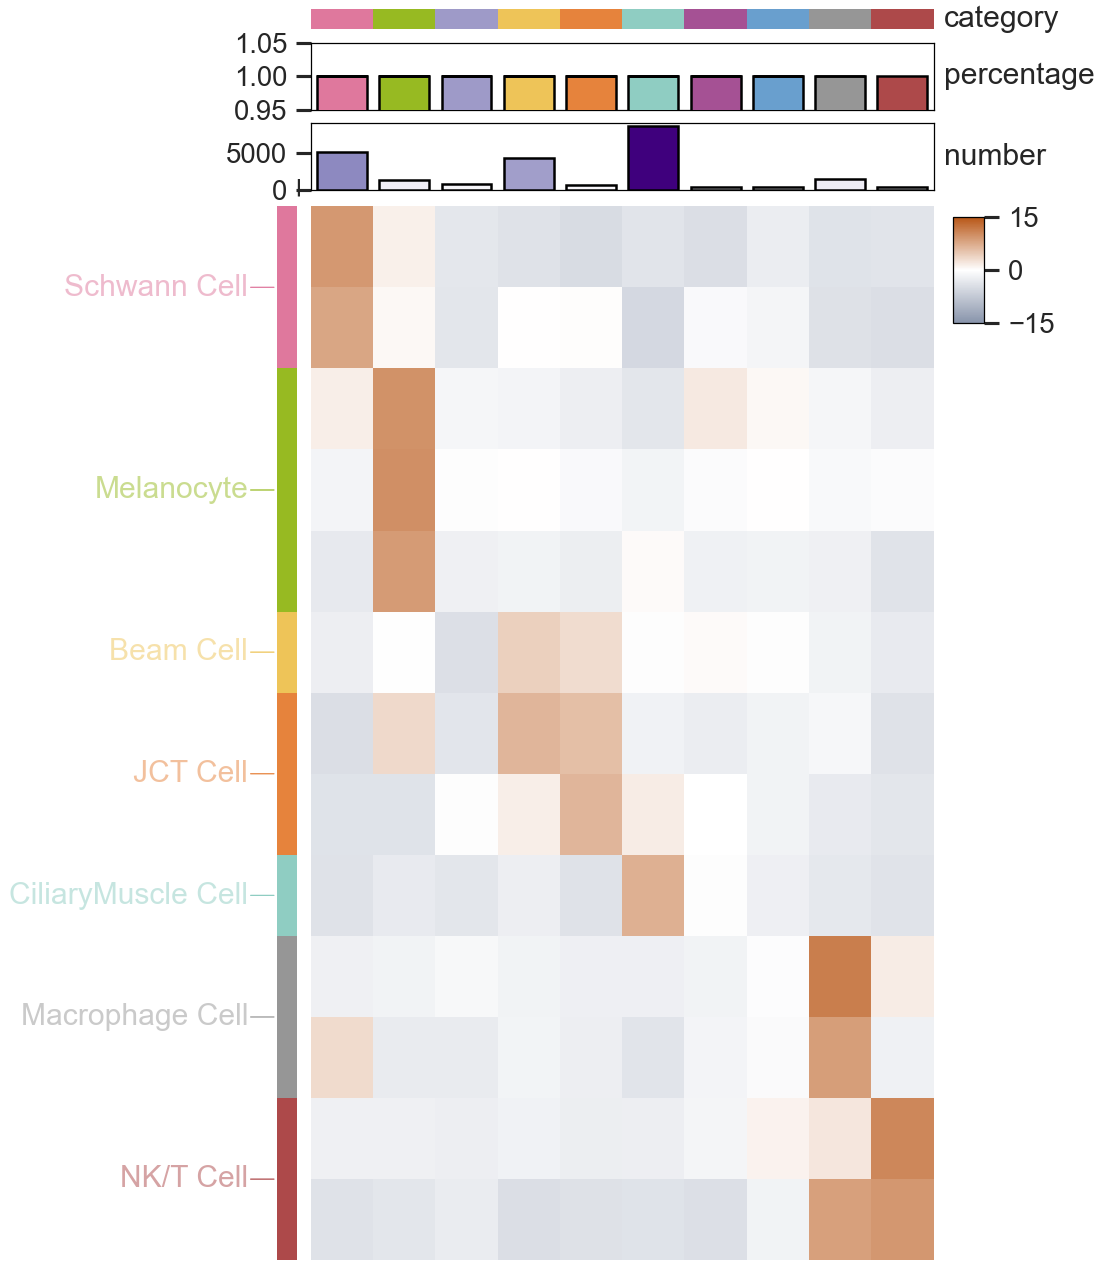

In [18]:
plot_heatmap(heat_info_dict=heat_info_dict, species='human', legend=True, need_row_ha=True, gene_group=gene_group, logfc_dict=logfc_dict, color_dict=ct_c, heat_cmap=custom_cmap)  # 'Greens'
# plt.savefig('heatmap_human.pdf', bbox_inches='tight')

Starting plotting HeatmapAnnotations


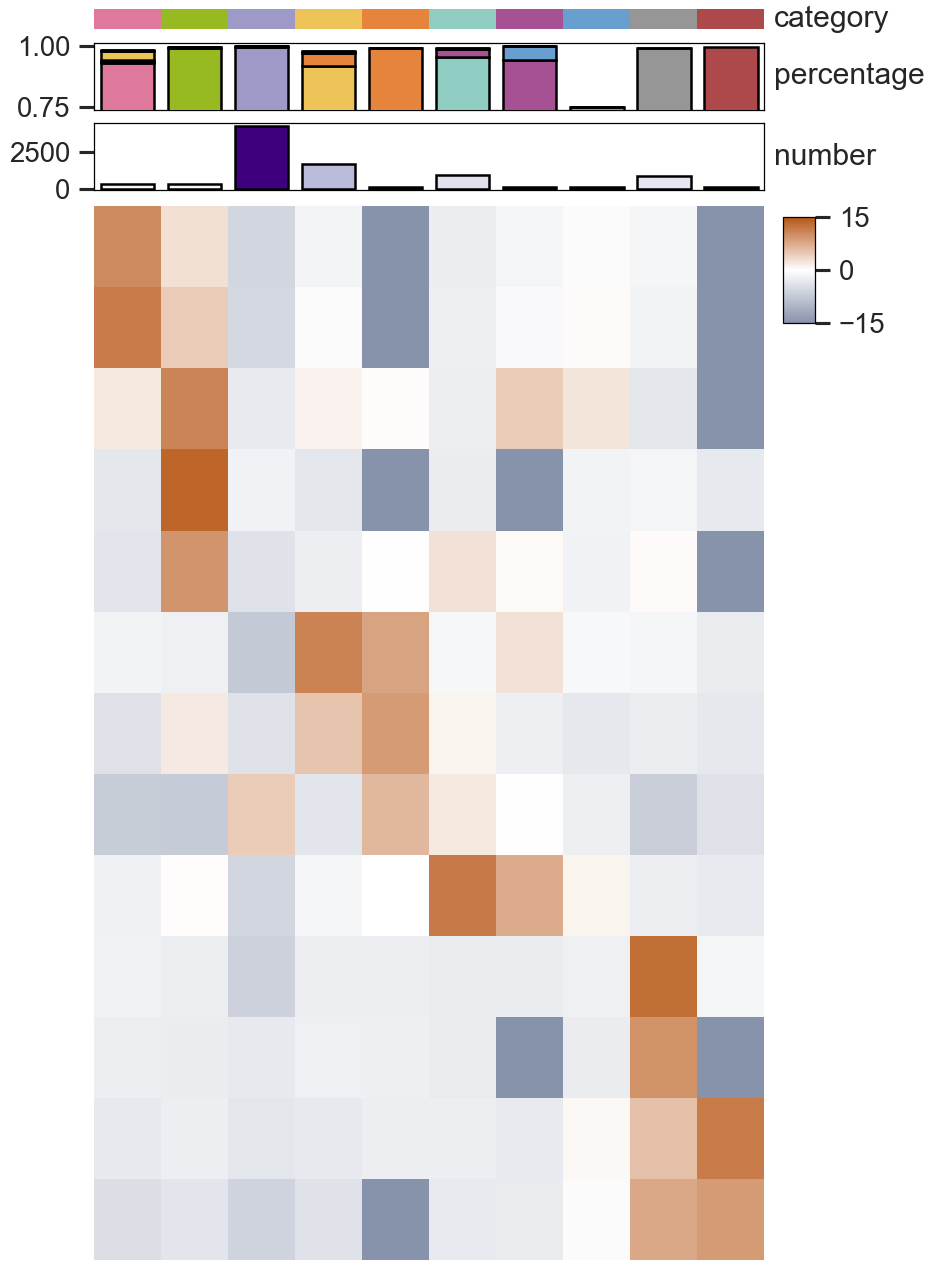

In [19]:
plot_heatmap(heat_info_dict=heat_info_dict, species='mf', legend=True, need_row_ha=False, gene_group=gene_group, logfc_dict=logfc_dict, color_dict=ct_c, heat_cmap=custom_cmap)
# plt.savefig('heatmap_mf.pdf', bbox_inches='tight')


Starting plotting HeatmapAnnotations


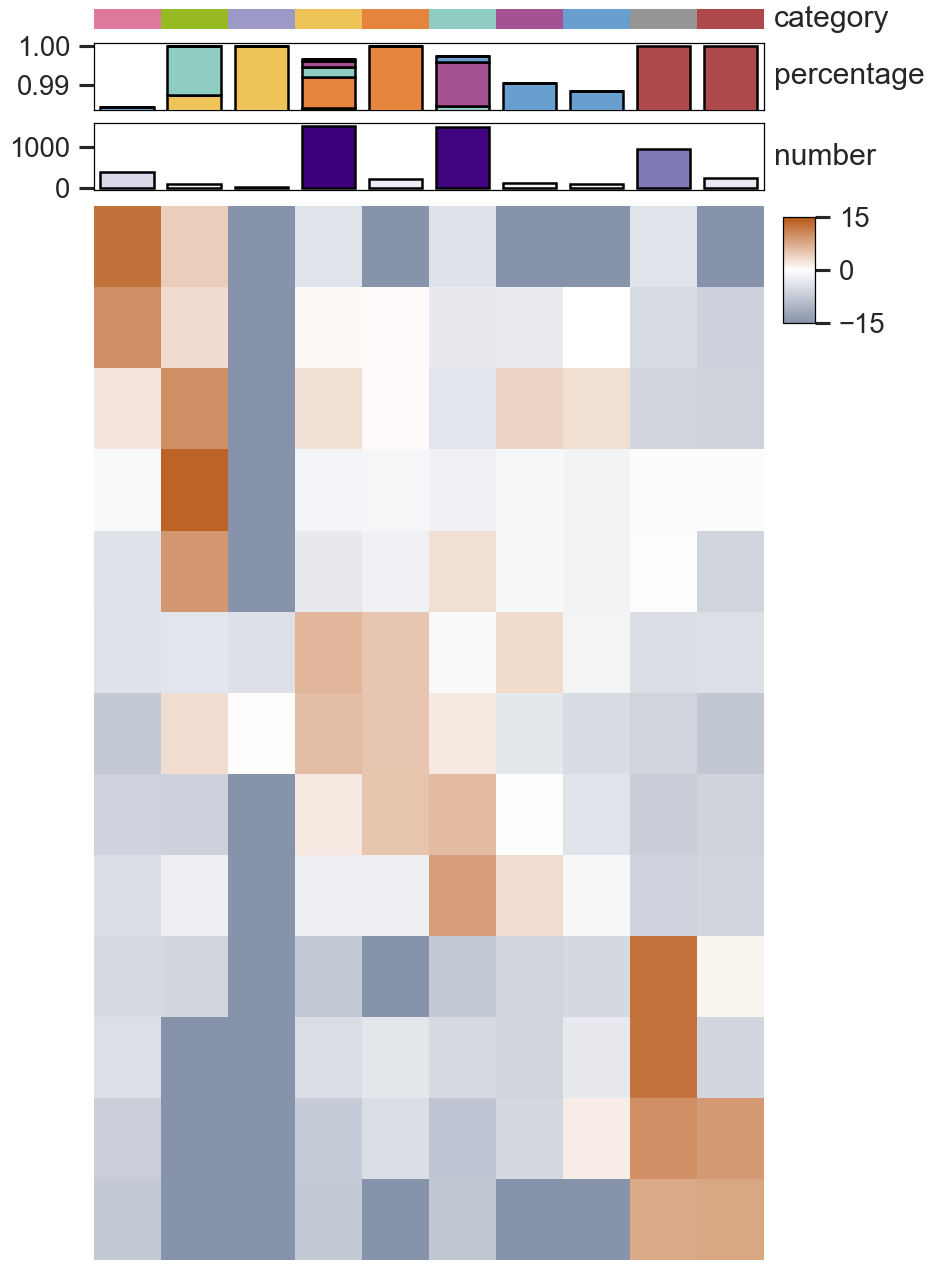

In [20]:
plot_heatmap(heat_info_dict=heat_info_dict, species='mm', legend=True, need_row_ha=False, gene_group=gene_group, logfc_dict=logfc_dict, color_dict=ct_c, heat_cmap=custom_cmap)
# plt.savefig('heatmap_mm.pdf', bbox_inches='tight')


Starting plotting HeatmapAnnotations


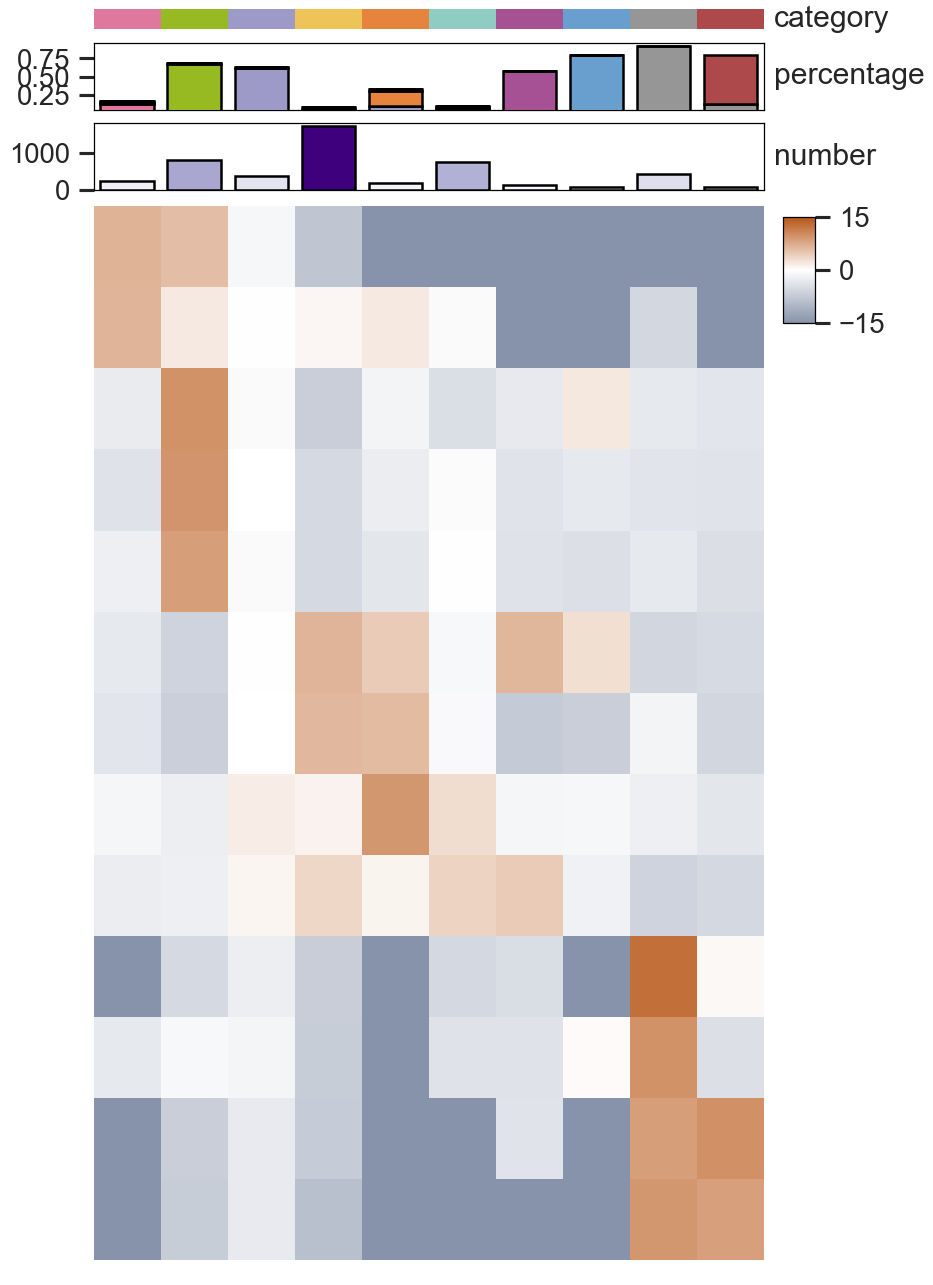

In [21]:
plot_heatmap(heat_info_dict=heat_info_dict, species='mouse', legend=True, need_row_ha=False, gene_group=gene_group, logfc_dict=logfc_dict, color_dict=ct_c, heat_cmap=custom_cmap)
# plt.savefig('heatmap_mouse.pdf', bbox_inches='tight')